<a href="https://colab.research.google.com/github/wadeyman/Variational-Autoencoders/blob/main/Generative_Model_Basic_Variational_Autoencoder_(VAE).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A standard Autoencoder consists of an Encoder and a Decoder. The Encoder maps the input data to a lower-dimensional latent space (typically a vector of numbers), while the Decoder maps the latent space back to the original data space.

**The VAE Encoder maps the input data to a probability distribution over a latent space. Instead of a fixed-length vector, the latent space is represented as a continuous distribution, such as a Gaussian distribution.** This distribution encodes the probability of each possible latent vector. The VAE Decoder then generates a new sample from this distribution and maps it back to the original data space.

In my self tutorial,
first carry out preprocessing to the dataset from mnist, with each data/img being 28 * 28 pixels and adding one channel to it.

Next, build the model with it being only in dense layers for simplicity.
Train it and examine the model.

Finally, I will plot VAE Latent Space 2D Representation.
Predict the test set and generate some test reconstructed images.
And also plot the 2D manifold, generating randomly and plotting the digits.

In [1]:
import tensorflow as tf
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras import ops as K

In [2]:
(xtrain, ytrain), (xtest, ytest) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
xtrain.shape

(60000, 28, 28)

In [5]:
train_ds = tf.data.Dataset.from_tensor_slices((xtrain, xtrain))
# split the dataset into individual objects/datapoint
train_ds

<_TensorSliceDataset element_spec=(TensorSpec(shape=(28, 28), dtype=tf.uint8, name=None), TensorSpec(shape=(28, 28), dtype=tf.uint8, name=None))>

In [6]:
test_ds = tf.data.Dataset.from_tensor_slices((xtest, xtest))

In [7]:
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    label = tf.cast(label, tf.float32) / 255.0

    image = tf.expand_dims(image, axis = -1)
    label = tf.expand_dims(label, axis = -1)
    return image, label

# expand dims to make it one channel for each img

In [8]:
train_ds = train_ds.map(preprocess)
train_ds = train_ds.batch(32)
test_ds = test_ds.map(preprocess)
test_ds = test_ds.batch(32)

# makes it such that each training round feeds 32 images

![alt text](https://miro.medium.com/v2/resize:fit:720/format:webp/1*40pimI49nLU17zakyrxnpA.png)

In [10]:
# OOP, Model subclassing version
# simple version only using dense layers, not using convo for now
# we use 2 dim to visualise the normal distribution our vectors in the latent space
class Encoder(keras.layers.Layer):
    def __init__(self, latent_dim=2):
      super(Encoder, self).__init__()
      self.latent_dim = latent_dim
      self.flatten = Flatten() # 28*28
      self.dense = Dense(64, activation='relu')
      self.z_mean = Dense(latent_dim) # 2 dim
      self.z_log_var = Dense(latent_dim) # 2 dim

    def call(self, inputs):
      x = self.flatten(inputs) # 28*28*1
      x = self.dense(x) # 64
      z_mean = self.z_mean(x) # 2
      z_log_var = self.z_log_var(x)
      return z_mean, z_log_var

In [13]:
class Decoder(keras.layers.Layer):
  def __init__(self):
    super(Decoder, self).__init__()
    self.dense = Dense(64, activation='relu')
    self.dense2 = Dense(28*28*1, activation='sigmoid')
    self.reshape = tf.keras.layers.Reshape((28, 28, 1))

  def call(self, inputs):
    x = self.dense(inputs)
    x = self.dense2(x)
    x = self.reshape(x)
    return x

In [14]:
class Sampling(keras.layers.Layer):
  def call(self, inputs):
    z_mean, z_log_var = inputs
    epsilon = tf.keras.random.normal(shape=tf.shape(z_mean))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [15]:
class VAE(keras.models.Model):
  def __init__(self):
    super(VAE, self).__init__()
    self.encoder = Encoder()
    self.decoder = Decoder()
    self.sampling = Sampling()
    self.z_mean = None
    self.z_log_var = None

  def call(self, inputs):
    self.z_mean, self.z_log_var = self.encoder(inputs)
    z = self.sampling([self.z_mean, self.z_log_var])
    reconstructed = self.decoder(z)
    return reconstructed

In [16]:
model = VAE() # instantiate the model

In [19]:
def vae_loss(y_true, y_pred): # this is the framework how defining custom loss
  kl_loss = -0.5 * tf.reduce_mean(1 + model.z_log_var - tf.square(model.z_mean) - tf.exp(model.z_log_var))
  reconstruction_loss = keras.losses.binary_crossentropy(y_true, y_pred)
  kl_weight = 1e-2
  return kl_weight * kl_loss + reconstruction_loss


In [20]:
model.compile(optimizer='adam', loss=vae_loss)
model.fit(train_ds, validation_data=test_ds, epochs=5)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 0.3095 - val_loss: 0.2375
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step - loss: 0.2347 - val_loss: 0.2332
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 0.2301 - val_loss: 0.2303
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 8ms/step - loss: 0.2276 - val_loss: 0.2286
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - loss: 0.2259 - val_loss: 0.2270


In [23]:
model.summary()

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder (Encoder)                    │ ?                           │          50,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder (Decoder)                    │ ?                           │          51,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sampling (Sampling)                  │ ?                           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 304,958 (1.16 MB)

 Trainable params: 101,652 (397.08 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 203,306 (794.17 KB)

In [34]:
'''keras.utils.plot_model(model, show_shapes=True,
                       show_dtype=True, show_layer_names=True,
                       expand_nested=True, dpi=200,
                       show_layer_activations=True, show_trainable=True)'''

'keras.utils.plot_model(model, show_shapes=True, \n                       show_dtype=True, show_layer_names=True, \n                       expand_nested=True, dpi=200, \n                       show_layer_activations=True, show_trainable=True)'

In [25]:
encoder = model.encoder
sampler = model.sampling
decoder = model.decoder

In [26]:
mean, log_var = encoder(xtest)
z = sampler((mean, log_var))

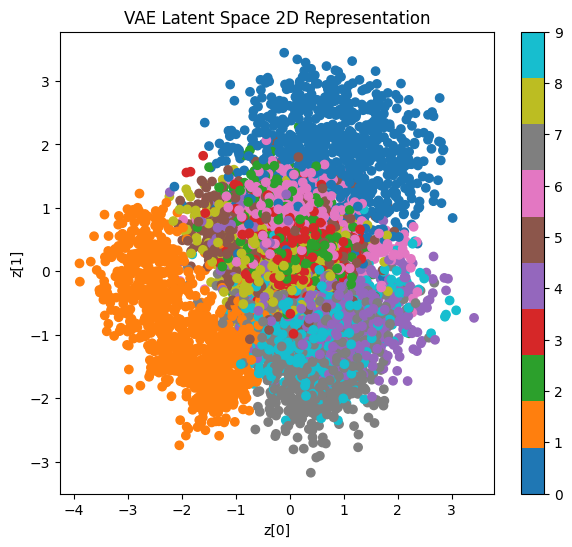

In [29]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7,6))
plt.scatter(z[:, 0], z[:, 1], c=ytest, cmap='tab10')
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.title("VAE Latent Space 2D Representation")
plt.show()

We observe that the digits and their z value vectors are represented normally, around 0 with a nice variance. Compared to just the Basic Autoencoder variation, we have no way of controlling how the model learns. The vectors could be all over the latent space, to infinity. Now we have a Gaussian model controlling the values learnt.

In [24]:
xtest = xtest.reshape(xtest.shape[0], 28, 28, 1)
xtest = xtest.astype('float32') / 255.0

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


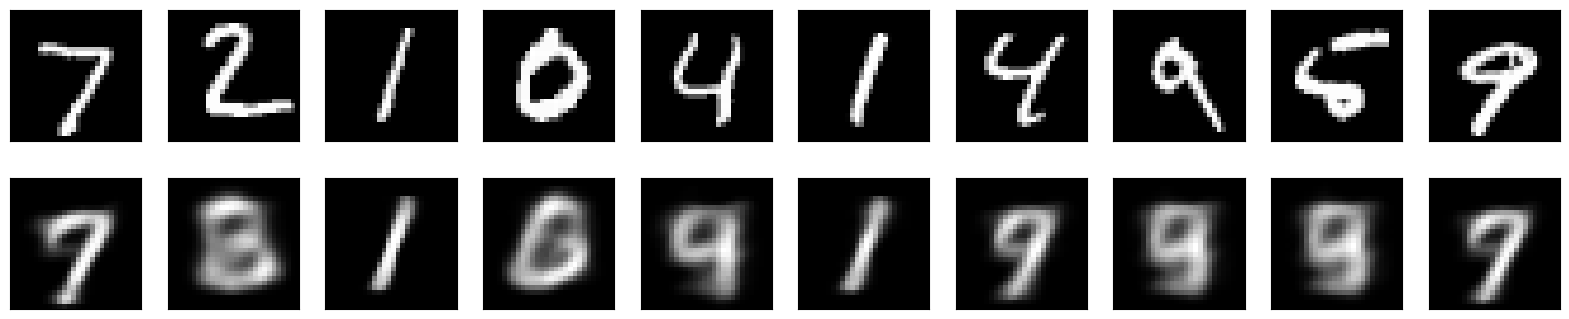

In [36]:
reconstructed = model.predict(xtest)
n = 10
plt.figure(figsize=(20, 4))
for i in range (n):
  # original images
  ax = plt.subplot(2, n, i+1)
  plt.imshow(xtest[i].reshape(28, 28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # recon images
  ax = plt.subplot(2, n, i+1+n)
  plt.imshow(reconstructed[i].reshape(28, 28))
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [42]:
xtest[0].shape

(28, 28, 1)

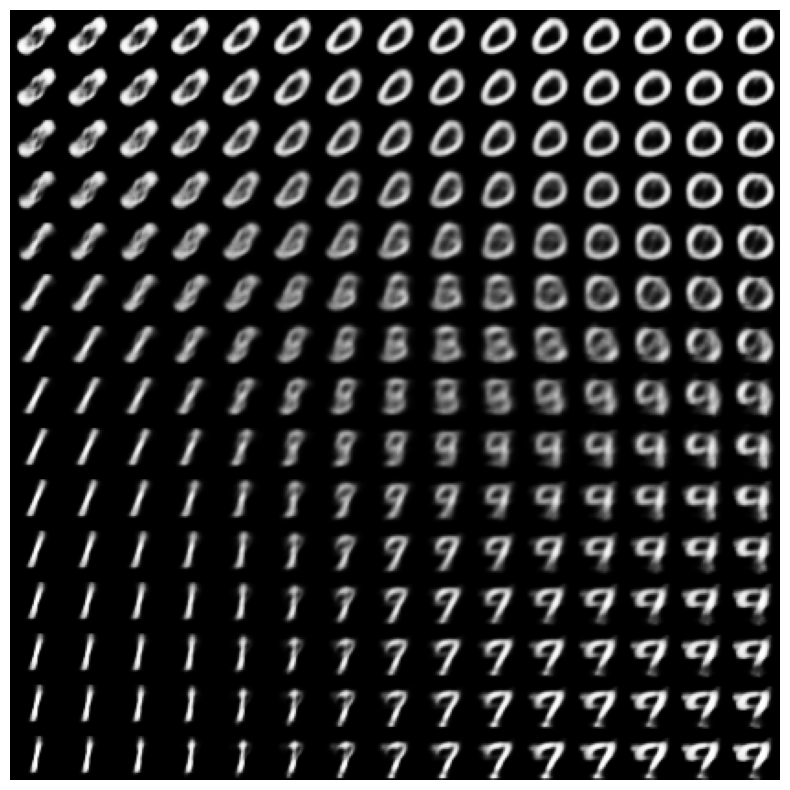

In [71]:
# Display a 2D manifold of the digits
import numpy as np
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# Sample n points within [-3, 3] standard deviations
grid_x = np.linspace(-3, 3, n)
grid_y = np.linspace(-3, 3, n)[::-1]  # reverse to plot top to bottom

# Iterate over the grid and decode each point
for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])  # Create a 2D latent variable
        # print(z_sample)
        # break
        z_sample = tf.convert_to_tensor(z_sample, dtype=tf.float32)
        x_decoded = decoder(z_sample)
        digit = tf.reshape(x_decoded[0], (digit_size, digit_size)).numpy()

        # Place the generated image on the grid
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

# Plot the resulting 2D manifold
plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='gray')
plt.axis('off')
plt.show()


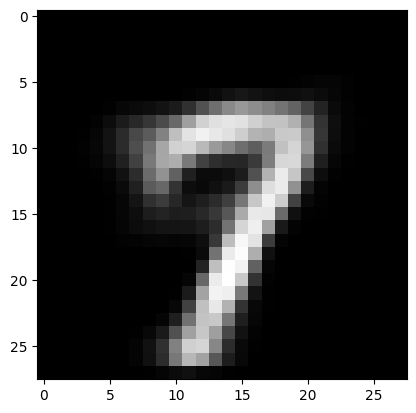

In [66]:
testz = sampler((mean[0], log_var[0]))
testz = tf.expand_dims(testz, axis=0)
recon = decoder(testz)
plt.imshow(recon[0], cmap='gray')

Credits:

https://www.kaggle.com/code/charel/learn-by-example-variational-autoencoder#The-variational-autoencoder-model

https://keras.io/api/ops/

https://www.youtube.com/watch?v=5G6Wz4RK3Ck

https://www.tensorflow.org/guide/keras/functional_api

Oreilly - Generative Deep Learning: Teaching Machines to Paint, Write, Compose, and Play